In [3]:
import pandas as pd
import numpy as np
import scipy as sp
from itertools import groupby
import matplotlib.pyplot as plt
import pickle
import torch
import json
import seaborn as sns
import os
import re
from sklearn import metrics
import random
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

C:\Users\annam\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read Data File

In [4]:
caid0 = pickle.load(open('caid0.pkl', "rb"))

In [69]:
reals = [item[2] for item in caid0]
flat_reals = [item for sublist in reals for item in sublist]
len(flat_reals)

338068

## Read DR-BERT predictions

In [6]:
object_file = pickle.load(open('df_caid.pickle', "rb"))

In [7]:
from scipy.special import softmax
logits = softmax(object_file,axis=1)[:,1]

In [8]:
DBscores = []
i=0
for row in caid0:
    l = len(row[1])
    DBscores.append(list(logits[i:i+l]))
    i+=l

In [9]:
df = pd.DataFrame(caid0,columns=['ID','seq','labs'])
df['scores'] = DBscores

In [10]:
df = df[df['seq'].str.len() < 1026]
ids = list(set(df['ID']))
df = df.set_index('ID')
df = df.loc[ids]

In [11]:
df

,seq,labs,scores
ID,,,
DP01574,MIKLSKKYCLGISFVLYILLSVCEGHKNLTCDFNDVYKLEFHPNQQ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.033798143, 0.05483449, 0.05005989, 0.044488..."
DP01600,MGSIMKINDLKSLISMQIAEFGGGEKIGRLKSTLQQVSTQAITSDE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.10977526, 0.4301516, 0.3514127, 0.35979432,..."
DP02170,MADRRRQRASQDTEDEESGASGSDSGGSPLRGGGSCSGSAGGGGSG...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.10198433, 0.417643, 0.4091482, 0.45075744, ..."
DP01286,GPSFCKADEKPCEYHADCCNCCLSGICAPSTNWILPGCSTSSFFKI,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.59851116, 0.6179483, 0.61105424, 0.6055336,..."
DP01947,MPMSQPAAPPVLTVRYEGSERTFAAGHDVVVGRDLRADVRVAHPLI...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.02651713, 0.30285722, 0.23200023, 0.3373924..."
...,...,...,...
DP01733,MADEFGNGDALDLPVGKDAVNSLIRENSHIFSDTQCKVCSAVLISE...,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0.103758015, 0.45041412, 0.4307161, 0.4556757..."
DP01875,MDIDNSNISTADIRSNTDGLIDIIMRILGFGNKNIVQPQDLGSEIY...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.17521685, 0.7761032, 0.7991557, 0.78854233,..."
DP02195,MRLLVSCVDSGSIKEVLCNIGTDTSVQSALQPFHVAPHLAEGLKAY...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.045286767, 0.02274896, 0.018803814, 0.02522..."


## Read CAID Results

In [12]:
files  = ["D014_fIDPnn.out",'D025_RawMSA.out','D029_SPOT-Disorder2.out','D018_ESpritz-D.out','D024_DisoMine.out','D026_AUCpreD.out','D004_IUPred2A-short.out','D002_Predisorder.out']
models = []
for file in files:
    model_name = file[:-4].split('_')[1]
    print(model_name)
    models.append(model_name)
    df2 = pd.read_csv(file, sep='\t', names=['i','AA','score','lab'])
    s = ''
    i=''
    lab=[]
    score = []
    fdict = {}
    bin_dict = {}
    for index, row in df2.iterrows():
        if row['i'][0]=='>':
            if s!='':
                fdict[i] = score
                bin_dict[i] = lab
                s = ''
                i=row['i'][1:]
                lab=[]
                score=[]
            else:
                i=row['i'][1:]
        else:
            s+=row['AA']
            lab.append(row['lab'])
            score.append(row['score'])
    fscore = [fdict[i] if i in fdict else np.nan for i in ids]
    df[model_name] = fscore
    labs = [bin_dict[i] if i in bin_dict else np.nan for i in ids]
    df[model_name+'_b'] = labs

fIDPnn
RawMSA
SPOT-Disorder2
ESpritz-D
DisoMine
AUCpreD
IUPred2A-short
Predisorder


In [13]:
df = df.dropna(axis='rows')
df

,seq,labs,scores,fIDPnn,fIDPnn_b,RawMSA,RawMSA_b,SPOT-Disorder2,SPOT-Disorder2_b,ESpritz-D,ESpritz-D_b,DisoMine,DisoMine_b,AUCpreD,AUCpreD_b,IUPred2A-short,IUPred2A-short_b,Predisorder,Predisorder_b
ID,,,,,,,,,,,,,,,,,,,
DP01574,MIKLSKKYCLGISFVLYILLSVCEGHKNLTCDFNDVYKLEFHPNQQ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.033798143, 0.05483449, 0.05005989, 0.044488...","[0.27, 0.265, 0.226, 0.233, 0.218, 0.204, 0.16...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3421273231506347, 0.3418872952461242, 0.340...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.764, 0.719, 0.651, 0.575, 0.492, 0.428, 0.3...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[0.179, 0.179, 0.18, 0.182, 0.171, 0.165, 0.15...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.237, 0.3, 0.318, 0.29, 0.31, 0.31, 0.271, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.998, 0.986, 0.931, 0.806, 0.608, 0.457, 0.3...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.442, 0.2865, 0.2432, 0.106, 0.0514, 0.0182,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.735, 0.566, 0.556, 0.523, 0.502, 0.309, 0.2...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
DP01600,MGSIMKINDLKSLISMQIAEFGGGEKIGRLKSTLQQVSTQAITSDE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.10977526, 0.4301516, 0.3514127, 0.35979432,...","[0.475, 0.5, 0.47, 0.453, 0.453, 0.408, 0.423,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3976524770259857, 0.4026190638542175, 0.405...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.781, 0.742, 0.653, 0.527, 0.394, 0.306, 0.2...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.295, 0.295, 0.298, 0.304, 0.304, 0.323, 0.3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.529, 0.556, 0.521, 0.494, 0.541, 0.617, 0.5...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 0.999, 0.993, 0.977, 0.951, 0.914, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.7951, 0.7605, 0.6604, 0.5473, 0.5126, 0.445...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.892, 0.709, 0.637, 0.576, 0.571, 0.542, 0.5...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
DP02170,MADRRRQRASQDTEDEESGASGSDSGGSPLRGGGSCSGSAGGGGSG...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.10198433, 0.417643, 0.4091482, 0.45075744, ...","[0.489, 0.526, 0.519, 0.623, 0.734, 0.591, 0.6...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.6503147482872009, 0.678048849105835, 0.7017...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.952, 0.965, 0.965, 0.962, 0.96, 0.961, 0.96...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.648, 0.653, 0.652, 0.646, 0.648, 0.654, 0.6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.807, 0.887, 0.913, 0.926, 0.948, 0.959, 0.9...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.9917, 0.9843, 0.9753, 0.9653, 0.9553, 0.939...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.988, 0.985, 0.988, 0.984, 0.988, 0.987, 0.9...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
DP01286,GPSFCKADEKPCEYHADCCNCCLSGICAPSTNWILPGCSTSSFFKI,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.59851116, 0.6179483, 0.61105424, 0.6055336,...","[0.648, 0.593, 0.422, 0.358, 0.271, 0.272, 0.2...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4119053483009338, 0.4100624918937683, 0.409...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.809, 0.807, 0.76, 0.719, 0.687, 0.668, 0.64...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.699, 0.697, 0.708, 0.707, 0.71, 0.703, 0.69...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.907, 0.919, 0.896, 0.864, 0.85, 0.821, 0.76...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.997, 0.983, 0.778, 0.448, 0.225, 0.153, 0.1...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6715, 0.37

## Calculate and Plot Metrics

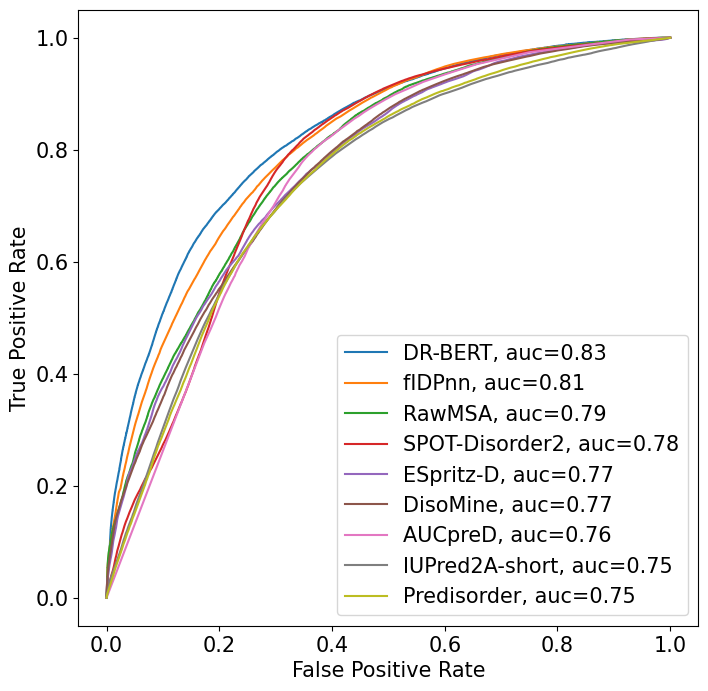

In [47]:
fig,ax1 = plt.subplots(figsize =(8, 8))
flat_trues = [item for sublist in df['labs'] for item in sublist]
aucs = []
mccs = []
f1s = []

drb = [item for sublist in df['scores'] for item in sublist]
b_drb = [1 if i>0.5 else 0 for i in drb]
fpr, tpr, _ = metrics.roc_curve(flat_trues, drb)
auc = metrics.roc_auc_score(flat_trues, drb)
aucs.append(auc)
mccs.append(metrics.matthews_corrcoef(flat_trues, b_drb))
f1s.append(metrics.f1_score(flat_trues, b_drb))
plt.plot(fpr,tpr,label="DR-BERT, auc="+str(round(auc, 2)))

for model in models:
    scores = [item for sublist in df[model] for item in sublist]
    labs = [item for sublist in df[model+'_b'] for item in sublist]
    #labs = [1 if i>0.5 else 0 for i in scores]
    fpr, tpr, _ = metrics.roc_curve(flat_trues, scores)
    auc = metrics.roc_auc_score(flat_trues, scores)
    aucs.append(auc)
    mccs.append(metrics.matthews_corrcoef(flat_trues, labs))
    f1s.append(metrics.f1_score(flat_trues, labs))
    
    plt.plot(fpr,tpr,label=model+", auc="+str(round(auc, 2)))

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.legend(loc=4,fontsize=15)
plt.savefig('ROC.pdf')
plt.show()

In [48]:
f1s

[0.5200835791543756,
 0.43908408112745795,
 0.4913737645476344,
 0.5030763381877148,
 0.41177717146565657,
 0.46531954716432555,
 0.4709546489956512,
 0.45532468784650243,
 0.4572755376523962]

In [49]:
mccs

[0.41670294994980117,
 0.3526446319821337,
 0.3501927293310375,
 0.37030364833868484,
 0.30190666095427177,
 0.31517116256361405,
 0.3211751938082759,
 0.30527462748661316,
 0.3102139066710563]

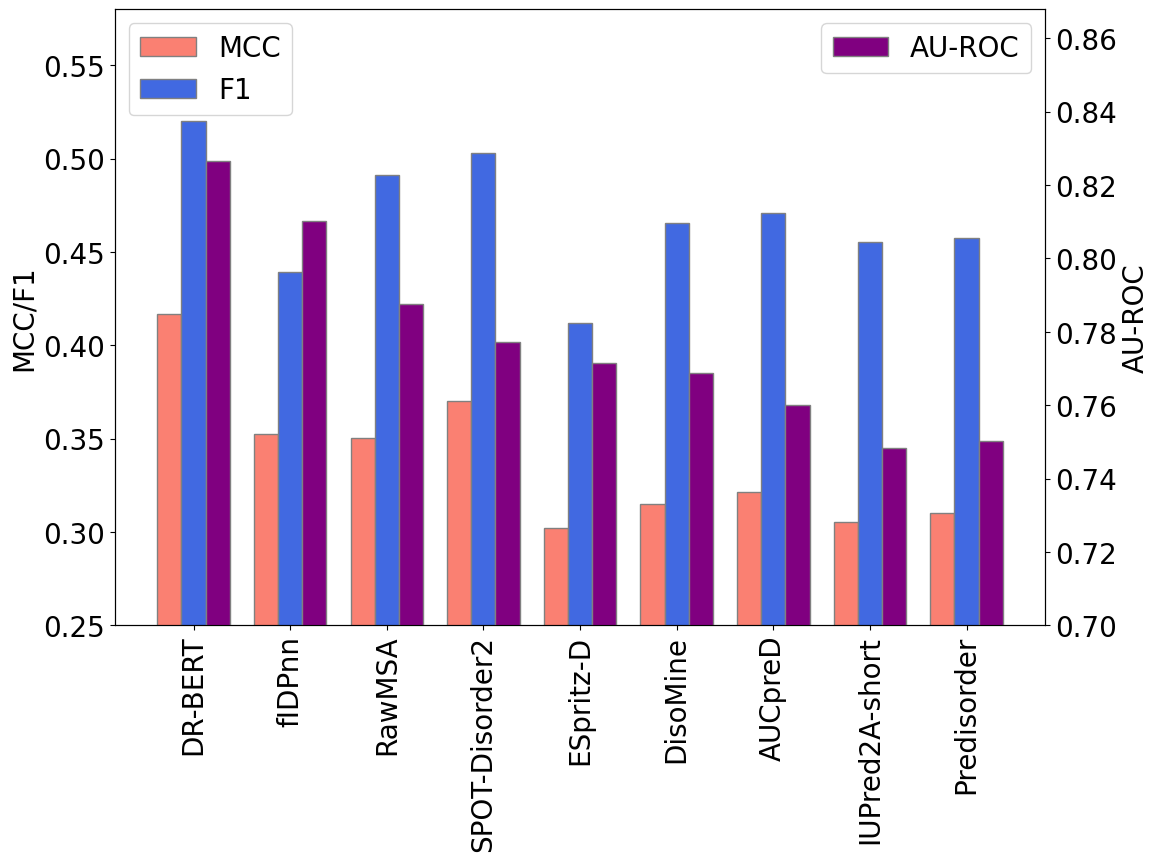

In [57]:
# set width of bar
barWidth = 0.25
fig,ax1 = plt.subplots(figsize =(12, 8))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20, rotation=90)
ax2 = ax1.twinx()  

# Set position of bar on X axis
br1 = np.arange(len(mccs))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
ax1.bar(br1, mccs, color ='salmon', width = barWidth,
        edgecolor ='grey', label ='MCC')
ax1.bar(br2, f1s, color ='royalblue', width = barWidth,
        edgecolor ='grey', label ='F1')

ax2.bar(br3, aucs, color ='purple', width = barWidth,
        edgecolor ='grey', label ='AU-ROC')

plt.xlabel('Model', fontsize = 20)
ax1.set_ylabel('MCC/F1',  fontsize = 20)
ax2.set_ylabel('AU-ROC',  fontsize = 20)
plt.xticks([r + barWidth for r in range(len(mccs))],
        ['DR-BERT']+models,fontsize=20)
ax1.set_ylim(bottom=0.25,top=0.58)
ax2.set_ylim(bottom=0.7)
ax1.legend(loc=2,fontsize=20)
ax2.legend(loc=0,fontsize=20)
plt.yticks(fontsize=20)
#plt.xticks()[1].set_color("red")
plt.savefig('Comparisons.pdf')
plt.show()

## Make Resampling Results

In [38]:
# Don't need to re-run this cell again. Saved the results already
"""
mcc_reps = []
auc_reps = []
f1_reps = []
for i in range(20):
    df_samp = df.sample(frac=0.25)
    df_samp.to_csv('Sampled/samp'+str(i)+'.csv')
    flat_trues = [item for sublist in df_samp['labs'] for item in sublist]
    aucs = []
    mccs = []
    f1s = []

    drb = [item for sublist in df_samp['scores'] for item in sublist]
    b_drb = [1 if i>0.5 else 0 for i in drb]
    auc = metrics.roc_auc_score(flat_trues, drb)
    aucs.append(auc)
    mccs.append(metrics.matthews_corrcoef(flat_trues, b_drb))
    f1s.append(metrics.f1_score(flat_trues, b_drb))

    for model in models:
        scores = [item for sublist in df_samp[model] for item in sublist]
        labs = [item for sublist in df_samp[model+'_b'] for item in sublist]
        #labs = [1 if i>0.5 else 0 for i in scores]
        auc = metrics.roc_auc_score(flat_trues, scores)
        aucs.append(auc)
        mccs.append(metrics.matthews_corrcoef(flat_trues, labs))
        f1s.append(metrics.f1_score(flat_trues, labs))
    mcc_reps.append(mccs)
    auc_reps.append(aucs)
    f1_reps.append(f1s)
mcc_reps = np.array(mcc_reps)
auc_reps = np.array(auc_reps)
f1_reps = np.array(f1_reps)
"""

In [61]:
mcc_reps = []
auc_reps = []
f1_reps = []
for i in range(20):
    df_ids = pd.read_csv('Sampled/samp'+str(i)+'.csv')['ID']
    df_samp = df.loc[df_ids]
    #df_samp.to_csv('Sampled/samp'+str(i)+'.csv')
    flat_trues = [item for sublist in df_samp['labs'] for item in sublist]
    aucs = []
    mccs = []
    f1s = []

    drb = [item for sublist in df_samp['scores'] for item in sublist]
    b_drb = [1 if i>0.5 else 0 for i in drb]
    auc = metrics.roc_auc_score(flat_trues, drb)
    aucs.append(auc)
    mccs.append(metrics.matthews_corrcoef(flat_trues, b_drb))
    f1s.append(metrics.f1_score(flat_trues, b_drb))

    for model in models:
        scores = [item for sublist in df_samp[model] for item in sublist]
        labs = [item for sublist in df_samp[model+'_b'] for item in sublist]
        #labs = [1 if i>0.5 else 0 for i in scores]
        auc = metrics.roc_auc_score(flat_trues, scores)
        aucs.append(auc)
        mccs.append(metrics.matthews_corrcoef(flat_trues, labs))
        f1s.append(metrics.f1_score(flat_trues, labs))
    mcc_reps.append(mccs)
    auc_reps.append(aucs)
    f1_reps.append(f1s)
mcc_reps = np.array(mcc_reps)
auc_reps = np.array(auc_reps)
f1_reps = np.array(f1_reps)

In [62]:
mcc_pvals = []
auc_pvals = []
f1_pvals = []
for i in range(1,len(mcc_reps[0])):
    mccs = mcc_reps[:,0]
    mccs_comp = mcc_reps[:,i]
    mcc_res = wilcoxon(mccs,mccs_comp, alternative='greater')
    mcc_pvals.append(-np.log10(mcc_res.pvalue))
    
    aucs = auc_reps[:,0]
    aucs_comp = auc_reps[:,i]
    auc_res = wilcoxon(aucs,aucs_comp, alternative='greater')
    auc_pvals.append(-np.log10(auc_res.pvalue))
    
    f1s = f1_reps[:,0]
    f1s_comp = f1_reps[:,i]
    f1_res = wilcoxon(f1s,f1s_comp, alternative='greater')
    f1_pvals.append(-np.log10(f1_res.pvalue))

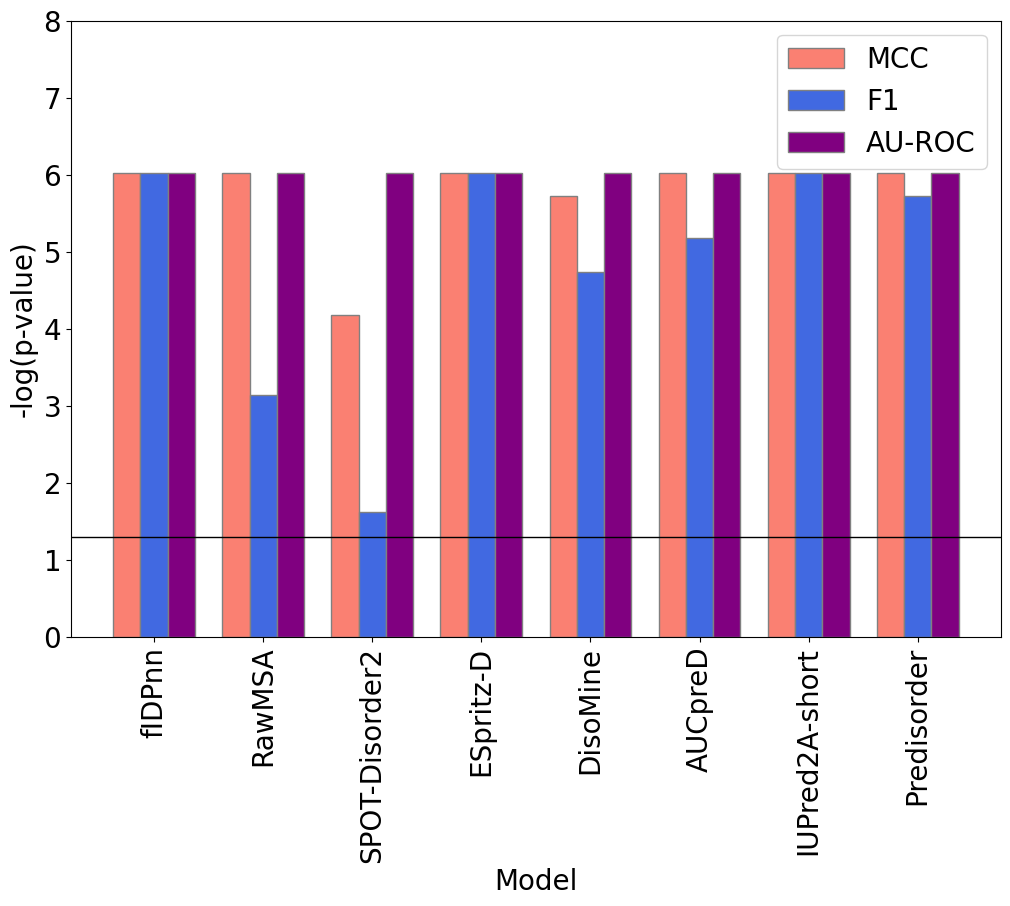

In [67]:
# set width of bar
barWidth = 0.25
fig,ax1 = plt.subplots(figsize =(12, 8))

plt.xticks(fontsize=20, rotation=90)

# Set position of bar on X axis
br1 = np.arange(len(mcc_pvals))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
ax1.bar(br1, mcc_pvals, color ='salmon', width = barWidth,
        edgecolor ='grey', label ='MCC')
ax1.bar(br2, f1_pvals, color ='royalblue', width = barWidth,
        edgecolor ='grey', label ='F1')

ax1.bar(br3, auc_pvals, color ='purple', width = barWidth,
        edgecolor ='grey', label ='AU-ROC')

plt.axhline(y=1.3,linewidth=1, color='k')

plt.xlabel('Model', fontsize = 20)
ax1.set_ylabel('-log(p-value)',  fontsize = 20)
plt.xticks([r + barWidth for r in range(len(mcc_pvals))],
        models)
#ax1.set_ylim(bottom=0.25)
#ax2.set_ylim(bottom=0.7)
plt.ylim(top=8)
plt.yticks(fontsize=20)
#ax1.set_yscale('log')
ax1.legend(fontsize=20)
plt.savefig('Comparisons_logpval.pdf')
plt.show()